In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pymc3 as pm
import patsy
import os, sys
import datetime as dt
from sklearn.cluster import KMeans
from sklearn.cross_validation import train_test_split
%matplotlib inline

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Initial research for a Bayesian fundamental risk premia hedge fund

**Assets Traded**
-----------------
1) Equities
    - Exact breakdown is TBD
    - Categorization will either be by sector (and separated by country), or by Market Cap.
    - Or, and this may be better, by volatiltiy. This allows combining Market Cap. with Sector
    - Securities will be ETFs capturing the relecant market
2) FX
    - Categorized by developed and developing markets
3) Commodities
    - Again captured by ETFs
    - Categorization is up in the air, but potentially by hard/soft commodities
4) Fixed income
    - Natural categorization could be rating
    
**Risk Premia Used**
------------------
1) Momentum
    - Start with SMA crossover
2) Value
3) Carry

**How is this Bayseian?**
-------------------
1) At the most basic level, the idea is to infer a hierarchical regression
    - Returns ~ Indicator*a + B
    - a, B inferred from hierarchy {Asset Type} -> {Categorization} -> {Security}
2) Also interested in inferring parameters for Risk Premia calculations
    -e.g, the exact windows for the moving averages in the momentum calculation

# Step 1:
## Collect data and calculate indicators

*Initial Securities List:
Equities:
- SPY (SP500)
- EFA (Extended developed markets)
- EWJ (Japan)
- FXI (China Large-cap)
- VWO (Emerging Markets)
- IJH (SP500 Mid-cap)
- IJR (SP500 Small-cap)
- IWF (Russell 1000 Growth)
- VIG (Divided Appreciation)


Fixed Income:
- LQD (Investment Grade Corporate)
- HYG (High-yield Coroporate)
- EMB (Emerging Market Debt)
- AGG (US Debt)

Commodities:
- GLD (Gold)
- UCO (Oil)
- JO (Coffee)
- SGG (Sugar)
- PPLT (Platinum)
- VXX (Volatility)

FX:
- UUP (USD)
- FXE (EURO)
- FXB (BPS)
- FXC (CAD)
- FXA (AUD)
- FXY (JPY)
- CEW (Emerging Markets)
- BZF (BRL)

In [2]:
root_dir = os.getcwd()

In [3]:
tickers = dict(
    SPY=dict(asset='equity'),
    EWJ=dict(asset='equity'),
    FXI=dict(asset='equity'),
    EFA=dict(asset='equity'),
    VWO=dict(asset='equity'),
    IJH=dict(asset='equity'),
    IJR=dict(asset='equity'),
    IWF=dict(asset='equity'),
    VIG=dict(asset='equity'),
    LQD=dict(asset='bond'),
    HYG=dict(asset='bond'),
    EMB=dict(asset='bond'),
    AGG=dict(asset='bond'),
    GLD=dict(asset='commodity'),
    UCO=dict(asset='commodity'),
    JO=dict(asset='commodity'),
    SGG=dict(asset='commodity'),
    PPLT=dict(asset='commodity'),
#     VXX=dict(asset='commodity'),
    UUP=dict(asset='fx'),
    FXE=dict(asset='fx'),
    FXB=dict(asset='fx'),
    FXY=dict(asset='fx'),
    CEW=dict(asset='fx'),
    BZF=dict(asset='fx'),
)

In [4]:
def vol_category_helper(row, *args):
    q0, q1, q2 = args[0], args[1], args[2]
    if row <= q0:
        return 0
    elif row <= q1:
        return 1
    elif row <= q2:
        return 2
    else:
        return 3

In [5]:
def corr_helper(row, *args):
    correl = args[0]
    try:
        return correl['SPY'][row.Date][row.ticker]
    except KeyError:
        return np.nan

In [6]:
def beta_helper(row, *args):
    spy = args[0]
    try:
        return (row['corr'] * row['vol']) / spy.loc[row['Date'], 'vol']
    except KeyError:
        return np.nan

In [7]:
def build_prices_dfs(tickers, n_categories=3):
    out = dict()
    for ticker in tickers.keys():
        df = pd.read_csv(root_dir+'/data/{}.csv'.format(ticker))
        df = df.replace({'null': np.nan})
        df['Close'] = pd.to_numeric(df['Close'])
        df['ticker'] = ticker
        df['Date'] = pd.to_datetime(df['Date'])
        df = df.set_index('Date', False)
        df['pct_change'] = pd.to_numeric(df['Close'].pct_change().shift(-1))
        df['log_return'] = (np.log(df.Close) - np.log(df.Close.shift(1))).shift(-1)
        
        # Calculate vol on a 1 year rolling basis
        df['vol'] = df['pct_change'].rolling(252).std()
        df['month_return'] = pd.to_numeric(pd.rolling_sum(df['pct_change'][::-1], window=22, min_periods=22)[::-1])
        df['month_log_return'] = pd.to_numeric(pd.rolling_sum(df['log_return'][::-1], window=22, min_periods=22)[::-1])
        df['asset_type'] = tickers[ticker]['asset']
        out[ticker] = df
    combined = pd.concat([_df for _df in out.values()])
    
    gb_equity = pd.DataFrame()
    for key, grp in combined.groupby('ticker'):
        gb_equity[key] = grp['log_return']
    correl = gb_equity.rolling(252).corr()
    combined['corr'] = combined.apply(corr_helper, axis=1, args=(correl, ))
    combined['beta'] = combined.apply(beta_helper, axis=1, args=(combined.loc[combined.ticker == 'SPY'], ))
    combined['beta_abs'] = combined['beta'].abs()
    combined['ra_return'] = combined['log_return'] / combined['beta']
    for key, grp in combined.groupby('ticker'):
        combined.loc[combined['ticker'] == key, 'ra_month_return'] = pd.rolling_sum(grp['ra_return'][::-1], window=22,
                                                                                    min_periods=22)[::-1]
    q1, q2, q3 = combined['vol'].quantile([.25, .5, .75])
    
    # Equities are placed into 4 vol categories based on their moment-in-time volatility relative to all historical
    # observed vols
    combined['category'] = combined['vol'].apply(vol_category_helper, args=(q1, q2, q3))
    return out, combined
        

In [8]:
prices, combined = build_prices_dfs(tickers, 3)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/matplotlib/pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


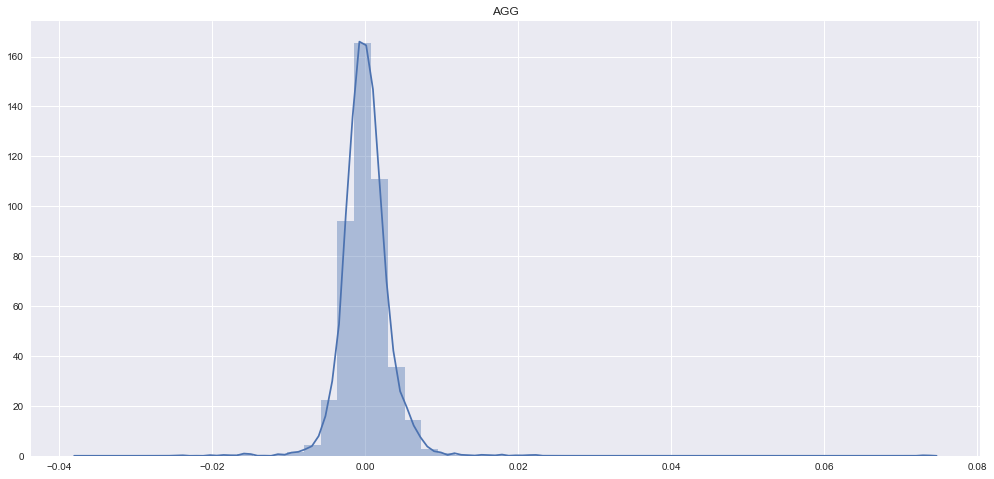

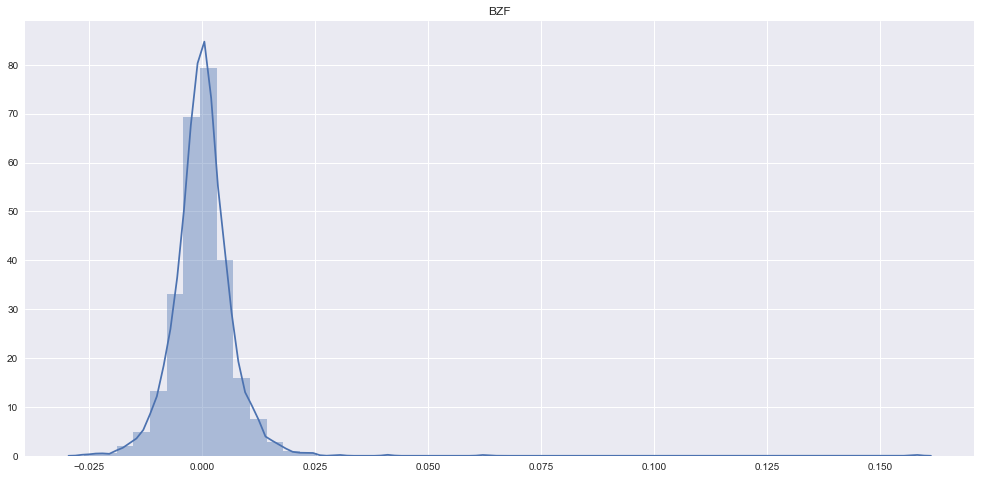

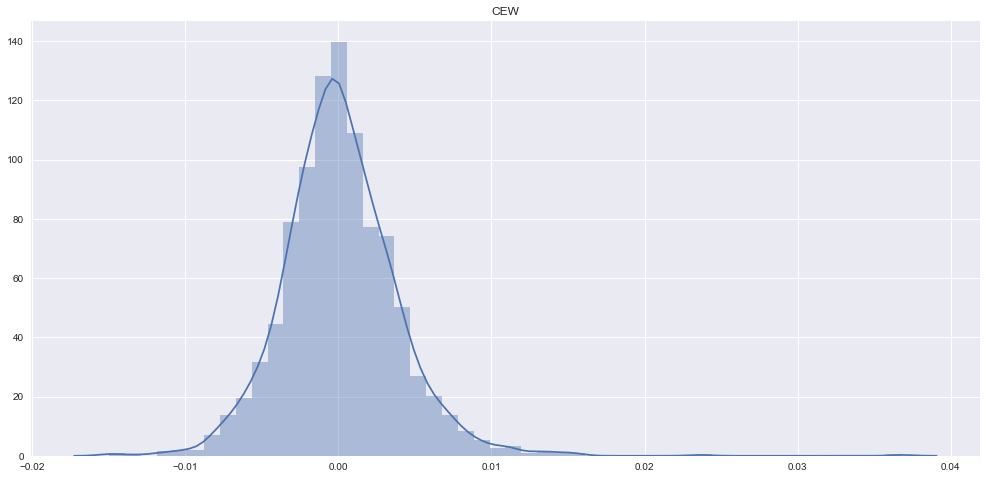

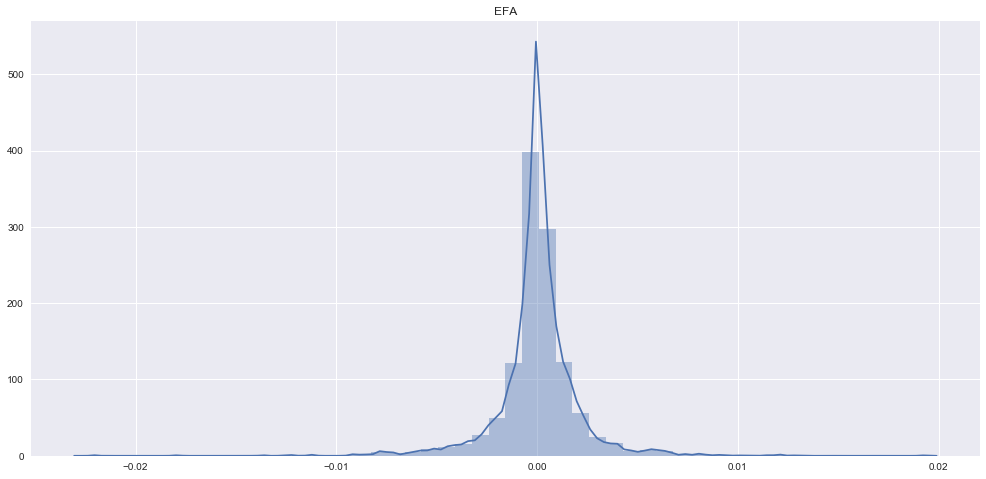

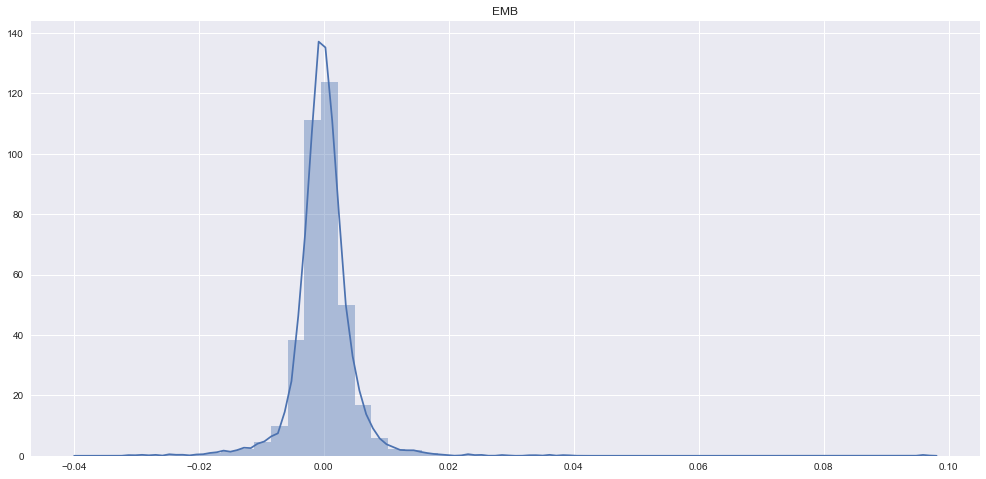

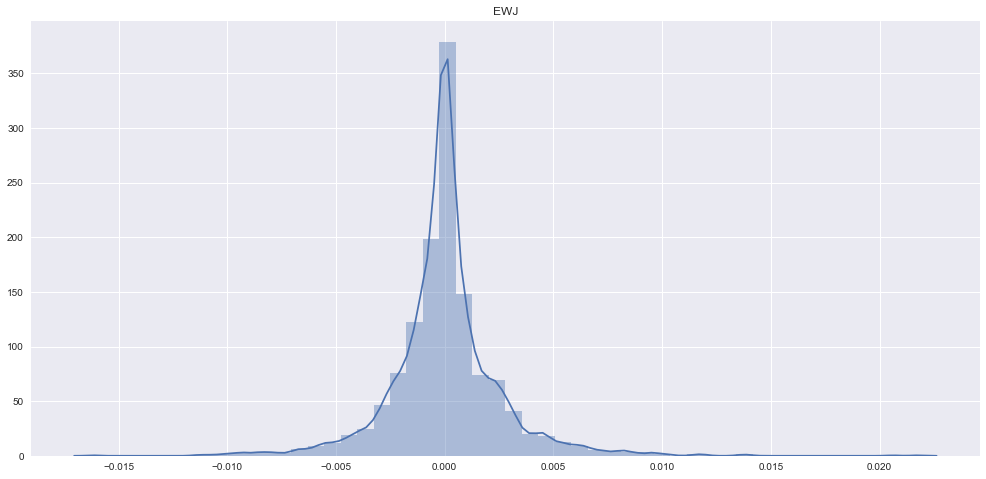

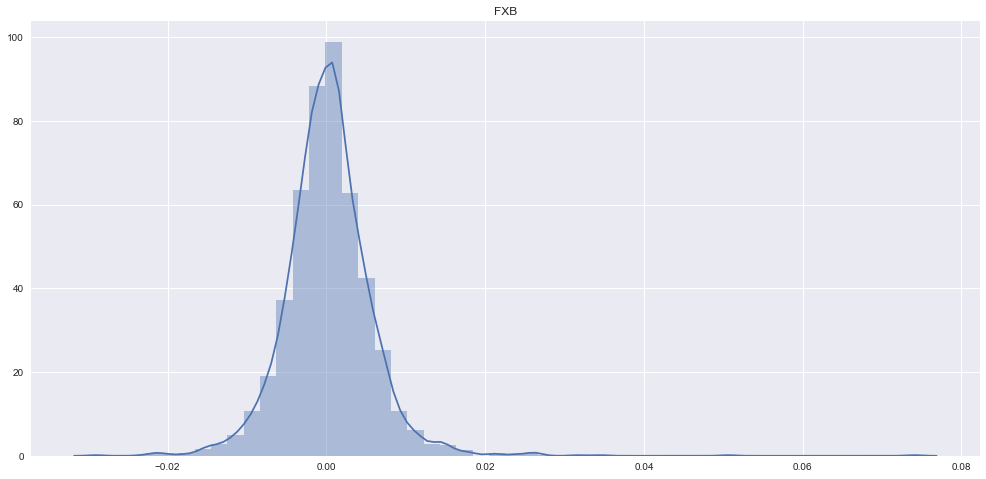

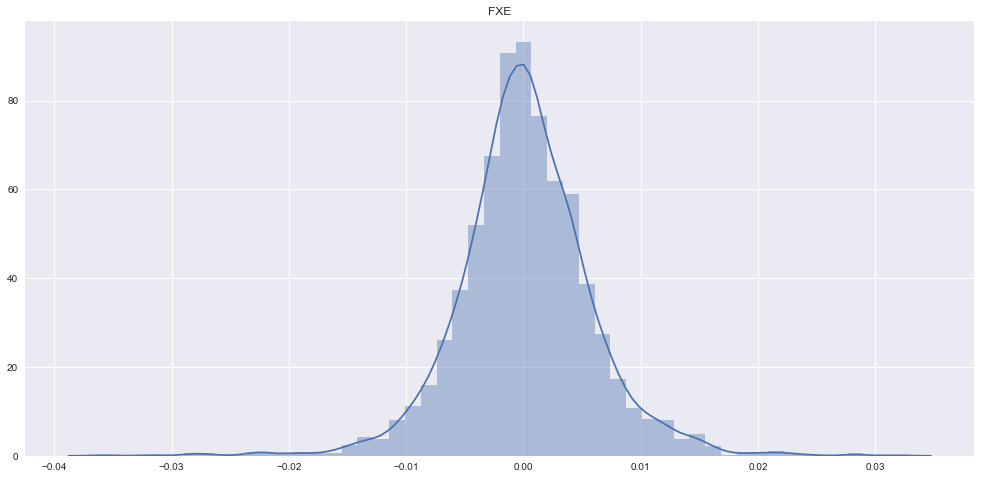

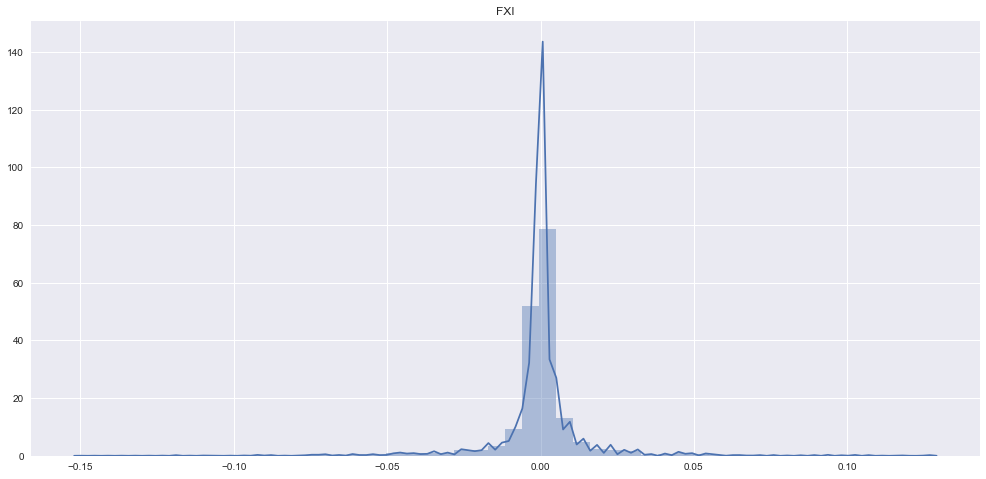

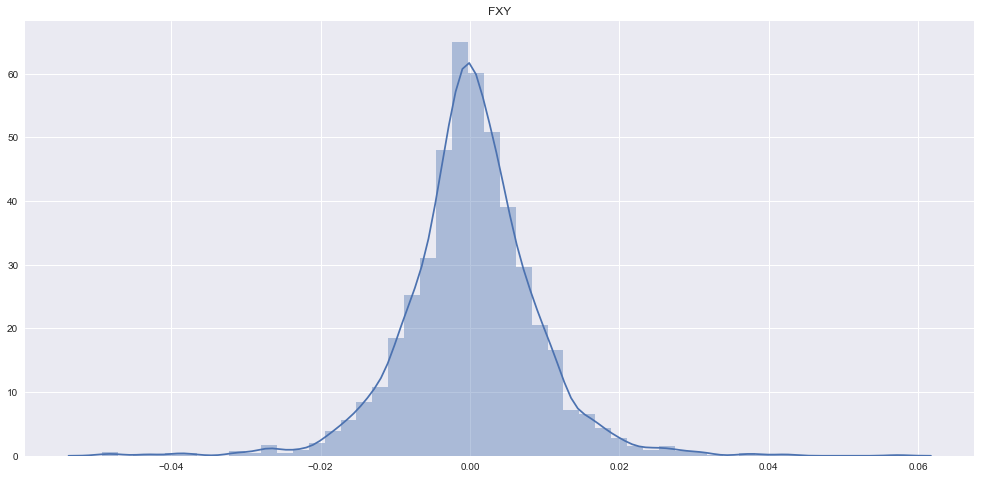

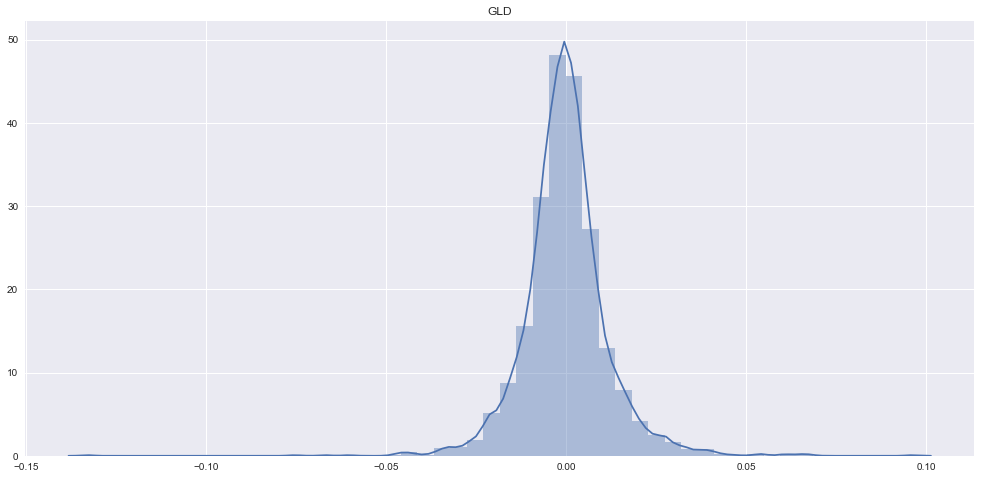

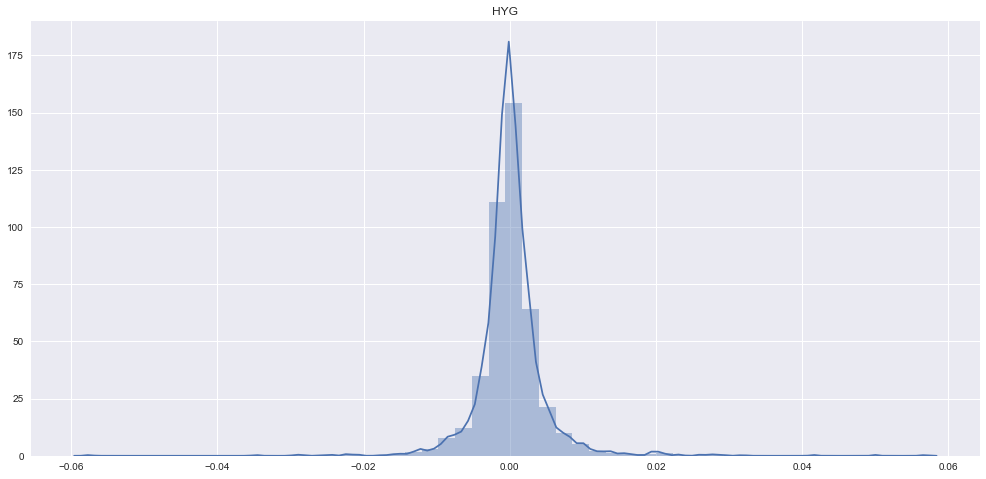

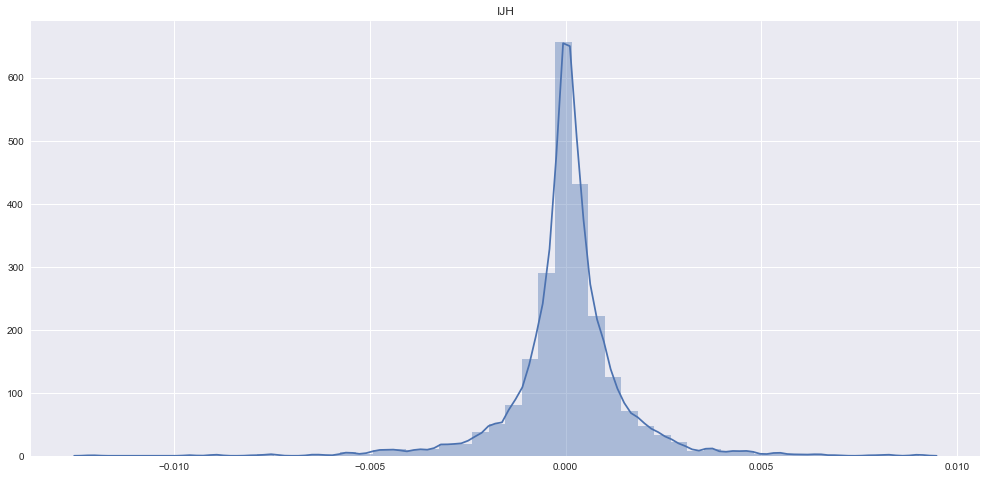

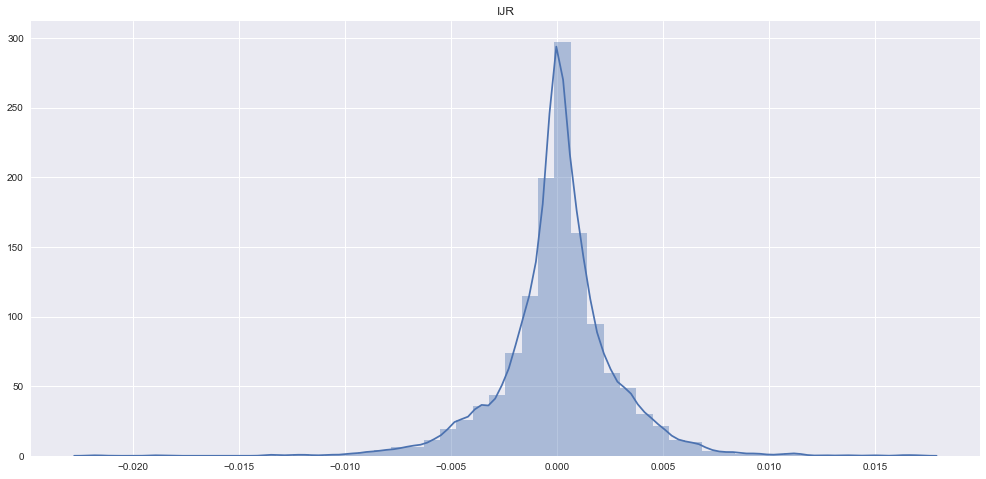

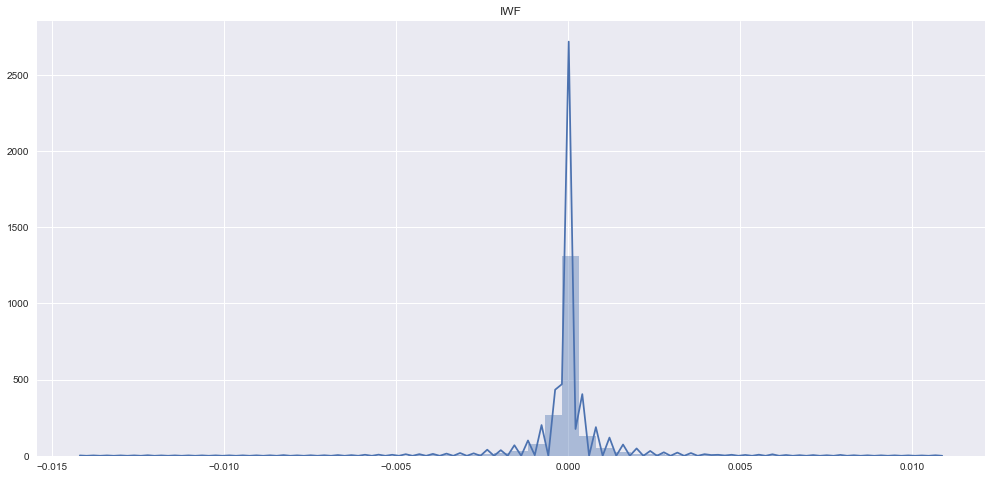

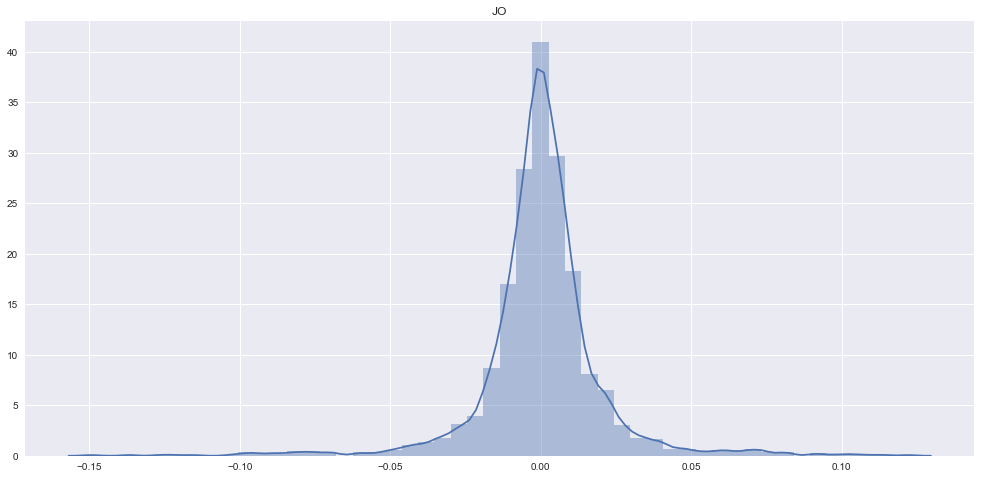

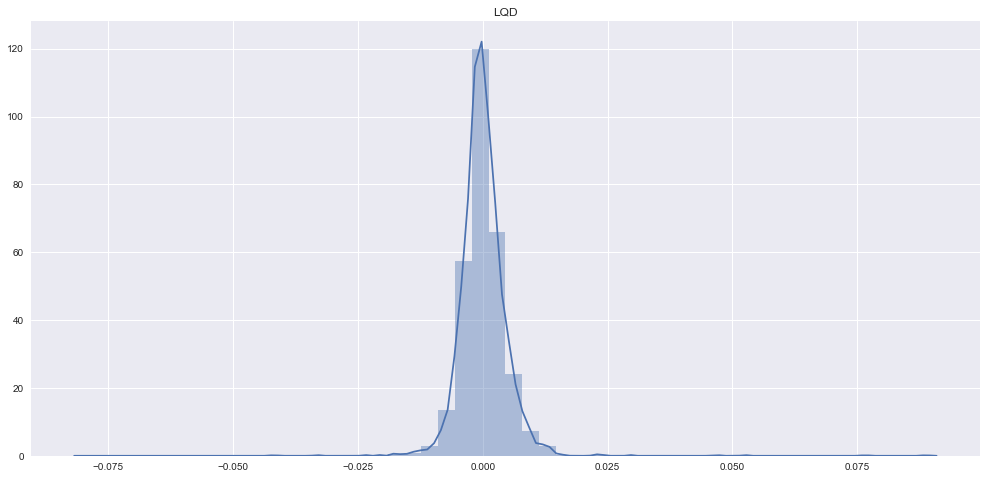

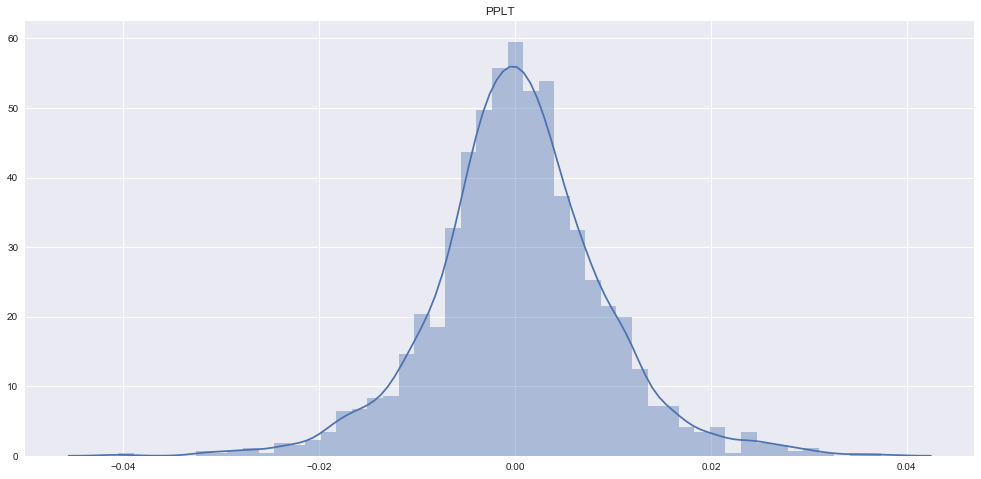

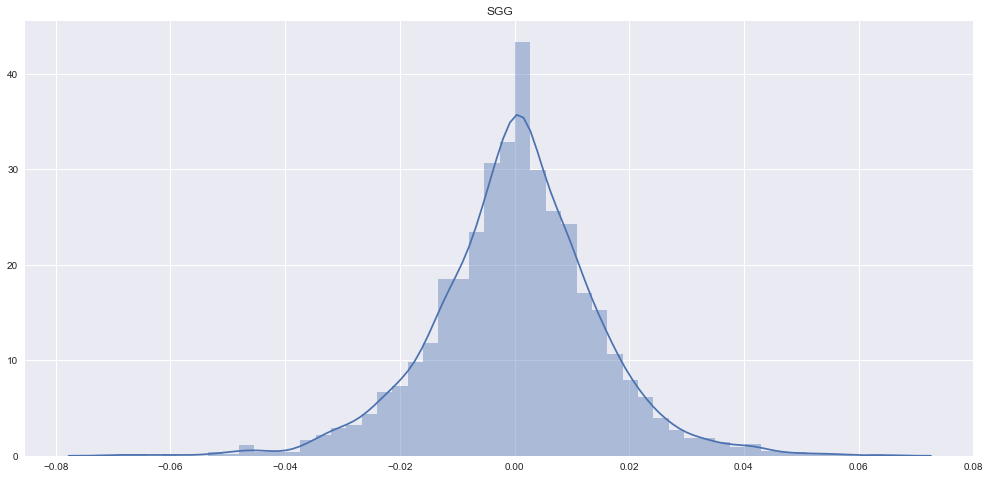

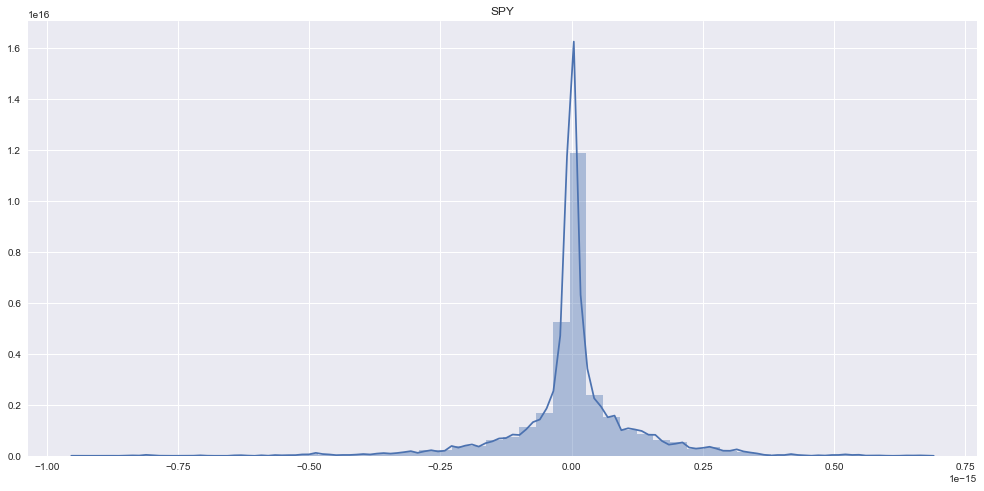

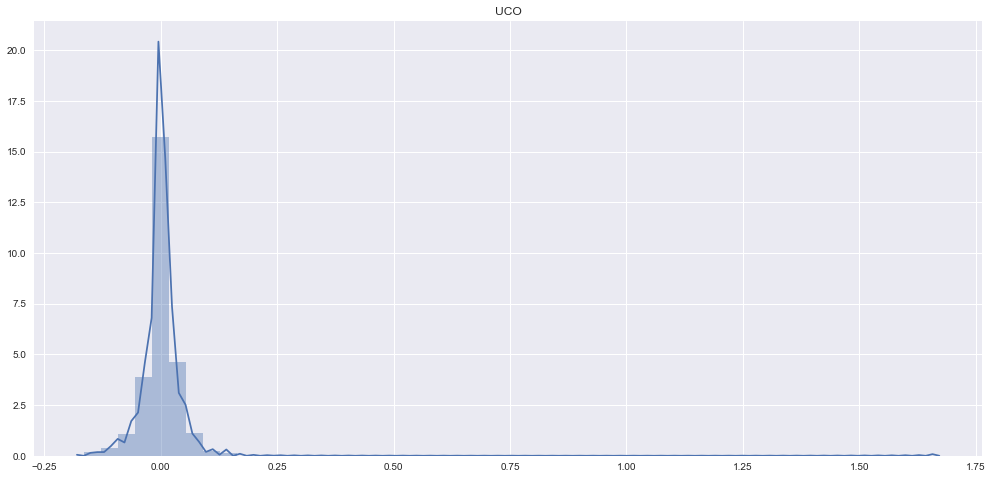

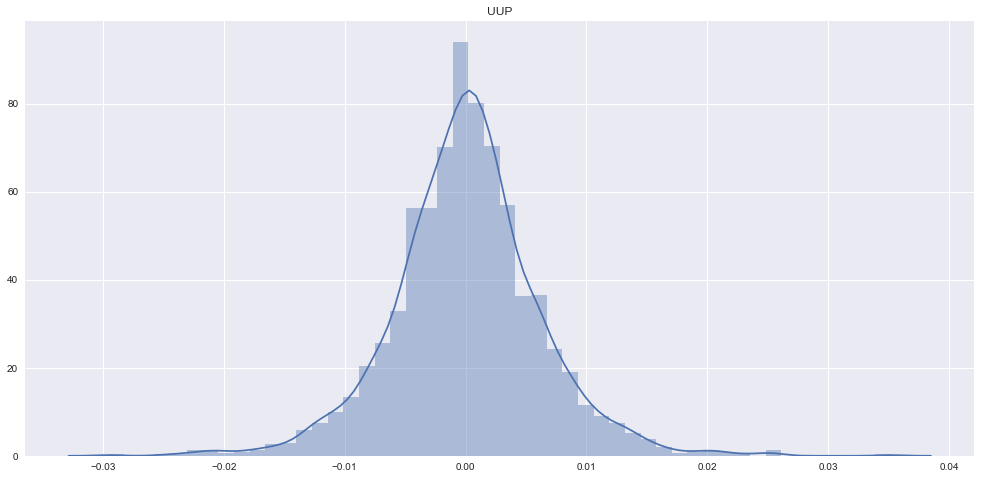

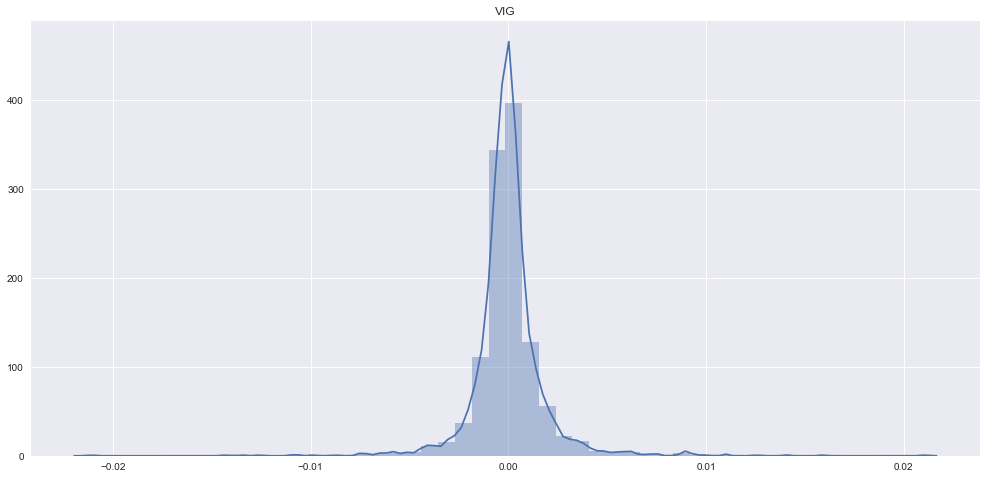

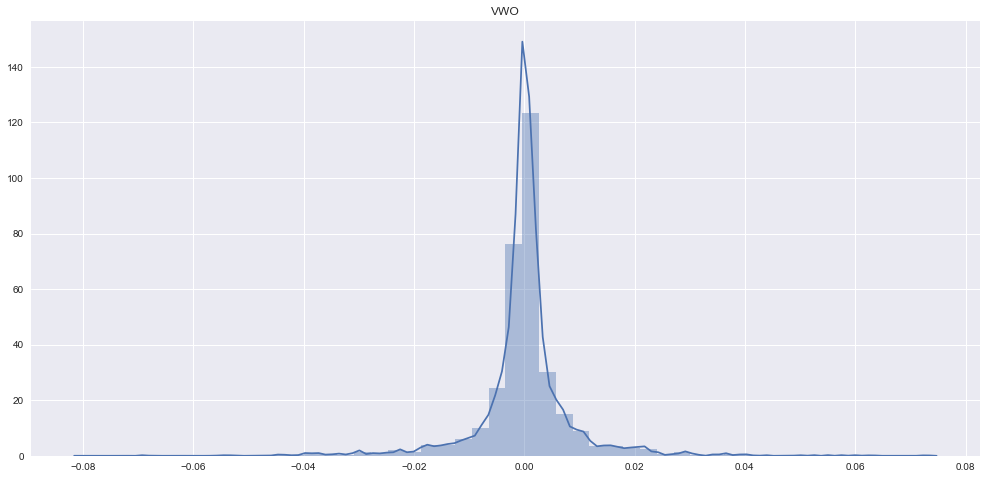

In [12]:
for key, grp in combined.groupby('ticker'):
    fig, ax = plt.subplots(figsize=(17, 8))
    sns.distplot((grp['ra_return'] - grp['log_return']).dropna(), ax=ax)
    plt.title(key)

In [13]:
category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

In [14]:
combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

In [49]:
combined.groupby('category').mean()[['vol']].sort_values('vol')

,vol
category,
0,0.004188
1,0.008097
2,0.012219
3,0.024759


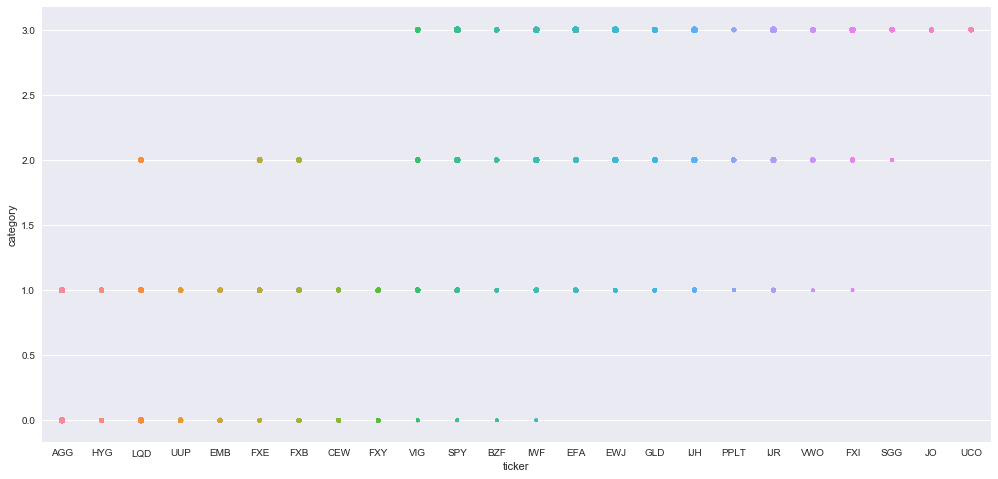

In [51]:
fig, ax = plt.subplots(figsize=(17, 8))
sns.stripplot(x='ticker', y='category', data=combined.sort_values('vol'), size=combined.sort_values('vol')['vol']*2000, ax=ax)
# sns.stripplot(x='ticker', y='vol', data=combined.sort_values('vol'), ax=ax)

# Step 2:
## Build hierarchical regression model

In [17]:
combined = combined.dropna()

In [18]:
combined.head()

,Date,Open,High,Low,Close,Adj Close,Volume,ticker,pct_change,log_return,...,month_log_return,asset_type,corr,beta,ra_return,ra_month_return,category,category_enc,asset_type_enc,security_enc
Date,,,,,,,,,,,,,,,,,,,,,
2008-02-28,2008-02-28,23.05,23.09,22.81,22.940001,22.7868,196600,UUP,0.000436,0.000436,...,-0.008317,fx,0.065040,0.033785,0.000091,0.001832,0,1,0,0
2008-02-29,2008-02-29,22.92,23.01,22.9,22.950001,22.7968,195300,UUP,-0.002179,-0.002181,...,-0.018470,fx,0.065425,0.034087,0.000002,0.000953,0,1,0,0
2008-03-03,2008-03-03,23,23,22.8,22.900000,22.7471,96300,UUP,0.002620,0.002617,...,-0.012745,fx,0.069131,0.035981,0.000171,0.001337,0,1,0,0
2008-03-04,2008-03-04,22.87,22.97,22.86,22.959999,22.8067,52300,UUP,-0.004791,-0.004802,...,-0.025139,fx,0.067941,0.035561,-0.000094,0.000370,0,1,0,0
2008-03-05,2008-03-05,22.92,22.97,22.82,22.850000,22.6974,74200,UUP,-0.005252,-0.005265,...,-0.013216,fx,0.073859,0.038405,-0.000126,0.001172,0,1,0,0


In [72]:
train[['value', 'vol', 'beta', 'ra_month_return']].corr()

,value,vol,beta,ra_month_return
value,1.000000,-0.434023,0.101897,-0.042218
vol,-0.434023,1.000000,0.551826,-0.003601
beta,0.101897,0.551826,1.000000,0.020609
ra_month_return,-0.042218,-0.003601,0.020609,1.000000


In [9]:
prices, combined = build_prices_dfs(tickers, 3)

slow_window = 252 * 3
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['value'] = pd.to_numeric((combined['Close'] - combined['slow']) / combined['slow'])
combined = combined.dropna()
    
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
#     a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
#     a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
    
    a_sec = pm.Normal('a_security', mu=a_category_mu, sd=a_category_sd, shape=n_securities)
#     a_vol = pm.Normal('a_vol', mu=0, sd=10)
#     a_beta = pm.Normal('a_beta', mu=0, sd=2)
    
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = ((
                (train['value'].values * a_sec[train['security_enc'].values])
#                 (train['vol'].values * a_vol)
            / train['beta_abs'].values
            ) + 
             b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    trace = pm.sample(200, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False,min_periods=22).sum()
 89%|████████▉ | 178/200 [5:11:58<3:43:15, 608.87s/it]

In [10]:
test.head()[['value', 'beta_abs', 'vol']]

,value,beta_abs,vol
Date,,,
2011-11-18,0.014221,0.453116,0.007784
2016-04-15,-0.099750,0.441631,0.012964
2012-11-16,0.002072,0.249677,0.004287
2015-09-29,-0.821369,1.646496,0.051639
2007-10-26,0.168241,1.000000,0.008431


KeyboardInterrupt: 

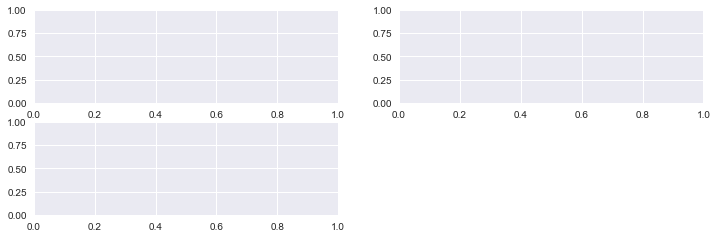

In [11]:
pm.traceplot(trace);

In [12]:
def calc_prediction_helper(row, *args):
    if args[0] == 'value':
        a = ((((row.value * trace['a_security'][:, row.security_enc]) *
               (row.vol * trace['a_vol'])) /
              (row.beta_abs)) + 
             trace['b_security'][:, row.security_enc])
    elif args[0] == 'momentum':
        a = ((((row.momentum * trace['a_security'][:, row.security_enc]) *
               (row.vol * trace['a_vol'])) /
              (row.beta_abs)) + 
             trace['b_security'][:, row.security_enc])
    return np.mean(a > 0)

In [13]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1, args=('value', ))

KeyError: ('a_vol', 'occurred at index 2011-11-18 00:00:00')

In [ ]:
sns.jointplot(test.prediction,
              test.ra_month_return)

In [ ]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['ra_month_return'].index,
              test.groupby('rounded_prediction').mean()['ra_month_return'])

In [67]:
for key, grp in test.groupby('category'):
    low, high = (.45, .55)
    print('Avg. return on long positions for category {}: {}'.format(key, grp.loc[grp.prediction >= high, 'month_log_return'].mean()))
    print('Avg. return on short positions for category {}: {}\n'.format(key, grp.loc[grp.prediction <= low, 'month_log_return'].mean()))

Avg. return on long positions for category 0: -0.0008238185628608067
Avg. return on short positions for category 0: -0.0015182498317807566

Avg. return on long positions for category 1: 0.007126089677360375
Avg. return on short positions for category 1: -0.00099411089930934

Avg. return on long positions for category 2: -0.0012030261532874687
Avg. return on short positions for category 2: -0.0017802639325479595

Avg. return on long positions for category 3: 0.006928423528720916
Avg. return on short positions for category 3: -0.019427439539944084



In [169]:
ticker_to_a = dict()
ticker_to_b = dict()
for t, i in security_encodings.items():
    ticker_to_a[t] = trace['a_security'][:, i]
    ticker_to_b[t] = trace['b_security'][:, i]

In [170]:
s = 'dict('
for t, a in ticker_to_a.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[-0.235770292087, -0.235770292087, -0.198383566428, -0.300678199789, -0.396725202596, -0.363557107773, -0.425105670492, -0.489227080773, 0.466136769105, -0.0805860054578, -0.0805860054578, 0.0894139269975, 0.0778771880814, 0.014419643121, 0.0679630691676, -0.0559069445845, -0.0730764311405, -0.073657634004, -0.190154082459, -0.190154082459, -0.0643146537194, -0.0275525233922, -0.022640651685, -0.031984437055, 0.0510589390687, -0.122292805809, -0.0233531131486, -0.0334406843474, 0.0510715897401, -0.135106443292, -0.135106443292, -0.00893039165593, -0.0798642823575, 0.00770811461151, -0.129937135962, -0.1761330052, 0.0440475762523, -0.0858693867684, -0.0324463868741, -0.0788090151922, -0.0788090151922, -0.197383093922, -0.117405294544, -0.0737402678261, -0.0434567206066, -0.0640645061761, -0.0213149582316, -0.105604354469, 0.0348805614401, 0.0197374151955, 0.0347340314659, -0.03690218226, -0.0699112726324, -0.107467109609, -0.107467109609, -0.0536805172179, -0.0743618504744, 0.0

In [171]:
s = 'dict('
for t, a in ticker_to_b.items():
    s += t + '=['
    for x in a:
        s += str(x) + ', '
    s = s[:-2]
    s += '],'
s = s[:-1]
s += ')\n'
print(s)

dict(FXB=[0.00106324141757, 0.00106324141757, -0.00200171689426, 0.0339307170897, 0.034721435226, 0.0341303349084, 0.034594245902, 0.0483986929442, 0.0278830880355, 0.00877137017657, 0.00877137017657, -0.00729790800577, -0.0200987199602, -0.023121659933, -0.0281960055463, -0.00677708338976, -0.0128099608971, 0.0199307573021, 0.00797895710954, 0.00797895710954, 0.00740213837217, 0.0474636217016, 0.0405479778601, -0.0461398401073, 0.00319278406193, -0.0191889425827, 0.0219182747859, -0.0241066552958, -0.01120981359, 0.0010570476653, 0.0010570476653, -0.0164886768808, 0.0268893032808, -0.0145347074718, 0.00922515538604, 0.00973791836518, -0.0191250309965, 0.0155932430422, -0.0215167784968, 0.00897713812422, 0.00897713812422, -0.0415178715587, -0.0142791879355, -0.0464264600373, -0.0467100304978, -0.00298858124612, -0.0230403246992, -0.00698489277227, -0.00733117110036, -0.000729941283837, -0.0108060507328, 0.0482722195332, 0.0101651986693, 0.0199745550851, 0.0199745550851, -0.004141094142

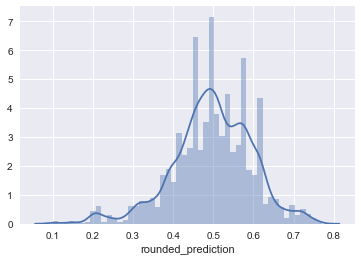

In [172]:
sns.distplot(test['rounded_prediction'])
# sns.distplot(combined['month_log_return'])

In [20]:
prices, combined = build_prices_dfs(tickers, 3)

fast_window = 7
slow_window = 25
for ticker in combined['ticker'].unique():
    combined.loc[combined['ticker'] == ticker, 'fast'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(fast_window).mean()
        
    combined.loc[combined['ticker'] == ticker, 'slow'] =\
    combined.loc[combined['ticker'] == ticker, 'Close'].rolling(slow_window).mean()
        
combined['momentum'] = pd.to_numeric((combined['fast'] - combined['slow']) / combined['slow'])
combined = combined.dropna()
    

category_encodings = dict((c, i) for i, c in enumerate(combined['category'].unique()))
asset_encodings = dict((a, i) for i, a in enumerate(combined['asset_type'].unique()))
security_encodings = dict((s, i) for i, s in enumerate(combined['ticker'].unique()))

combined['category_enc'] = combined['category'].apply(lambda x: category_encodings[x])
combined['asset_type_enc'] = combined['asset_type'].apply(lambda x: asset_encodings[x])
combined['security_enc'] = combined['ticker'].apply(lambda x: security_encodings[x])

groupby = 'category_enc'
sec_category_map = (combined.groupby(['security_enc',groupby]).size()
                  .reset_index()[groupby].values)

n_assets = len(asset_encodings)
n_categories = len(np.unique(sec_category_map))
n_securities = len(security_encodings)

train, test = train_test_split(combined, test_size=.3)

with pm.Model() as model:
    
    a_category_mu = pm.StudentT('a_category_mu', mu=0, sd=3, nu=1)
    a_category_sd = pm.HalfCauchy('a_category_sd', 2)
    
#     a_category = pm.Normal('a_category', mu=a_category_mu, sd=a_category_sd, shape=n_categories)
#     a_sec_sd = pm.Uniform('a_security_sd', 1, 5)
    
    a_sec = pm.Normal('a_security', mu=a_category_mu, sd=a_category_sd, shape=n_securities)
    a_vol = pm.Normal('a_vol', mu=0, sd=2)
    
#     b_category_mu = pm.Normal('b_category_mu', mu=0, sd=1)
#     b_category_sd = pm.HalfCauchy('b_category_sd', 2)
    
#     b_category = pm.Normal('b_category', mu=b_category_mu, sd=b_category_sd, shape=n_categories)
#     b_sec_sd = pm.HalfCauchy('b_security_sd', 2)
#     b_nu = pm.Uniform('b_nu', 1, 20)
#     b_mu = pm.Normal('b_mu', mu=0, sd=2)
#     b_sd = pm.Uniform('b_sd', 1, 3)
    b_sec = pm.Uniform('b_security', -1, 1, shape=n_securities)
    
    # Forward returns ~ Indicator * slope + intercept
    y_est = (train['momentum'].values * a_sec[train['security_enc'].values] + 
             train['vol'].values * a_vol +
             b_sec[train['security_enc'].values])
    epsilon = pm.Uniform('epsilon', 1, 5)
    nu = pm.Uniform('nu', 1, 20)
    
    likelihood = pm.StudentT('likelihood', nu=nu, mu=y_est, sd=epsilon, observed=train['ra_month_return'].values)
    trace = pm.sample(300, init='advi', n_init=50000, step=pm.NUTS())

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:15: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:16: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:31: FutureWarning: pd.rolling_sum is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=22,window=22).sum()
100%|██████████| 300/300 [36:26<00:00,  2.54s/it]


In [ ]:
test['prediction'] = test.apply(calc_prediction_helper, axis=1)

In [176]:
test['rounded_prediction'] = test['prediction'].round(2)
sns.jointplot(test.groupby('rounded_prediction').mean()['ra_month_return'].index,
              test.groupby('rounded_prediction').mean()['ra_month_return'])

KeyError: 'prediction'

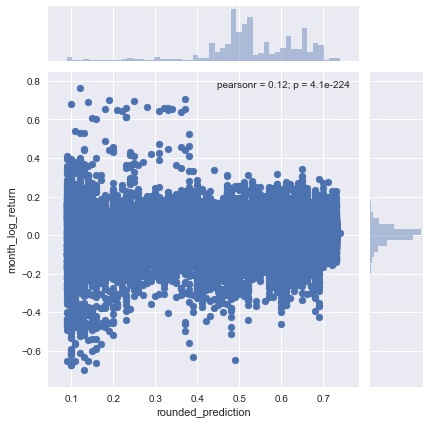

In [452]:
sns.jointplot('rounded_prediction', 'month_log_return', data=combined)

In [85]:
def eval_sharpe(returns, rf=.02):
    print("Mean returns: {}".format(np.mean(returns)))
    return (np.mean(returns)*252) / np.std(returns)

In [160]:
test['position'] = 0
low_p, high_p = .05, .95
for key, grp in test.groupby('category'):
    low, high = 1, 1
    sharpe = 0.
    p = 0
    for _p in np.arange(.05, .5, .05):
        _low, _high = grp['prediction'].quantile([_p, 1-_p])
        grp.loc[(grp.prediction >= _high), 'position'] = 1
        grp.loc[(grp.prediction <= _low), 'position'] = -1
        grp['bt_return'] = grp['log_return'] * grp['position']
        _sharpe = eval_sharpe(grp['bt_return'])
        if  _sharpe > sharpe:
            p = _p
            low = _low
            high = _high
            sharpe = _sharpe
    print('Sharpe for category {}: {}'.format(key, sharpe))
    print('Low p for category {}: {}'.format(key, p))
    print('High p for category {}: {}\n'.format(key, 1-p))

# test['bt_return'] = test['log_return'] * test['position']
# test['date'] = test.index

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = va

Mean returns: 3.1433826670701445e-05
Mean returns: 4.789103829090195e-05
Mean returns: 4.693757250377325e-05
Mean returns: 9.72145616454505e-05
Mean returns: 8.902355935454454e-05
Mean returns: 8.26853886060922e-05
Mean returns: 0.00010018309412473891
Mean returns: 9.17383407817489e-05
Mean returns: 0.0001244326460004749
Sharpe for category 0: 7.742321677732245
Low p for category 0: 0.2
High p for category 0: 0.8

Mean returns: 9.695425140875191e-06
Mean returns: 4.710537602201432e-05
Mean returns: 2.005079755249559e-05
Mean returns: 7.650769118137084e-06
Mean returns: 6.273122420955624e-05
Mean returns: -1.1731486422046613e-05
Mean returns: -6.963960209306051e-05
Mean returns: -3.6562475241370684e-05
Mean returns: -6.925904458391431e-05
Sharpe for category 1: 2.7668998682414703
Low p for category 1: 0.1
High p for category 1: 0.9

Mean returns: 5.2902371407743674e-05
Mean returns: -5.8668403869060104e-05
Mean returns: 8.431211966835585e-06
Mean returns: 7.698843890119518e-05
Mean retu

In [73]:
print("Standard deviation of returns: {}".format(test['bt_return'].std()))
print("Standard deviation of benchmark returns: {}".format(test['log_return'].std()))

Standard deviation of returns: 0.0062795539460378655
Standard deviation of benchmark returns: 0.013830688271598368


/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


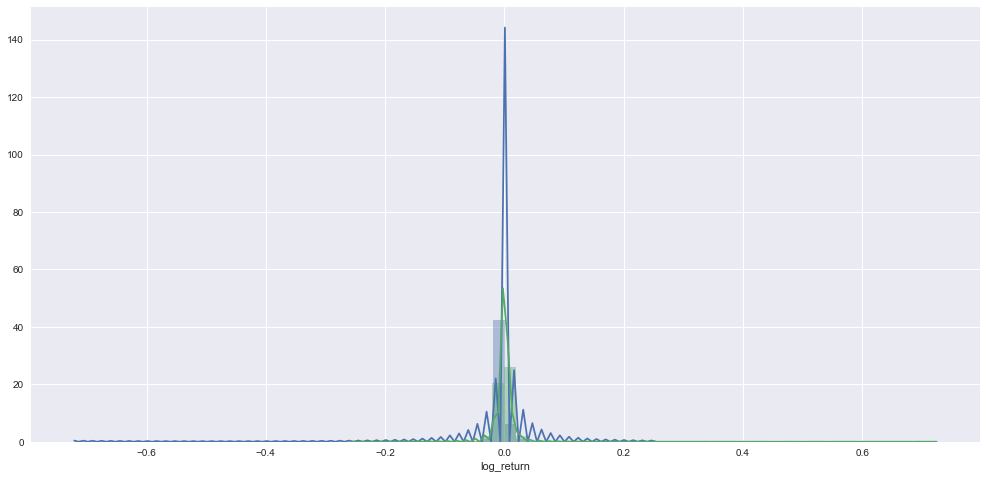

In [162]:
fig, ax = plt.subplots(figsize=(17, 8))
test.loc[test.prediction <= .4, 'position'] = -1
test.loc[test.prediction >= .6, 'position'] = 1
test['bt_return'] = test['position'] * test['log_return']
sns.distplot(test['bt_return'], ax=ax)
sns.distplot(test['log_return'], ax=ax)

/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  if __name__ == '__main__':
/Users/benjaminglickenhaus/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: 'Date' is both a column name and an index level.
Defaulting to column but this will raise an ambiguity error in a future version
  from ipykernel import kernelapp as app


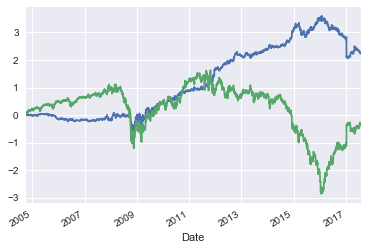

In [166]:
test.groupby('Date').sum()['bt_return'].cumsum().plot()
test.groupby('Date').sum()['log_return'].cumsum().plot()

In [318]:
# Calculate likelihood of positive forward month returns
a = (.02 * trace['a_security'][:, 10] + trace['b_security'][:, 10])
np.mean(a > 0)

0.98570000000000002

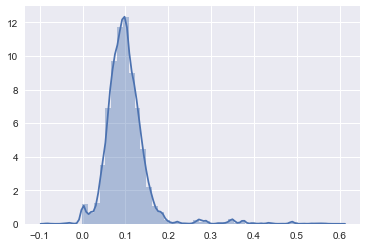

In [319]:
sns.distplot(trace['a_security'][:, 10])

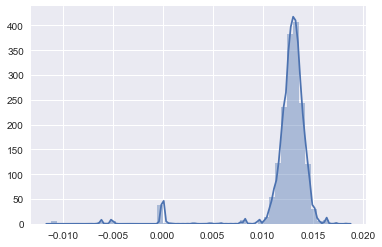

In [320]:
sns.distplot(trace['b_security'][:, 10])

In [327]:
np.mean(combined.loc[combined.security_enc==10, 'month_log_return'])

0.004074313702555441

In [168]:
security_encodings

{'AGG': 4,
 'EFA': 7,
 'EMB': 2,
 'HYG': 3,
 'IJH': 1,
 'IJR': 6,
 'IWF': 5,
 'LQD': 0,
 'SPY': 9,
 'VIG': 8,
 'VWO': 10}

In [326]:
combined.loc[:, ['momentum', 'month_log_return', 'prediction', 'security_enc']].sort_values('month_log_return')

,momentum,month_log_return,prediction,security_enc
Date,,,,
2008-09-25,-0.076662,-0.632523,0.93090,10
2008-09-24,-0.081097,-0.559686,0.91230,10
2008-09-22,-0.084976,-0.496025,0.89490,10
2008-09-25,-0.032976,-0.476216,0.97245,7
2008-09-19,-0.084898,-0.462080,0.89495,10
2008-09-25,-0.030162,-0.459665,0.97435,1
2008-09-23,-0.083429,-0.450323,0.90190,10
2008-09-26,-0.075104,-0.446928,0.93620,10
2008-09-25,-0.012921,-0.425113,0.98040,6


In [227]:
pd.DataFrame([1,2,3,4]).shift(1).rolling(3).mean()

,0
0,NaN
1,NaN
2,NaN
3,2.0
